In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib_inline.backend_inline

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import BaggingClassifier, AdaBoostClassifier
from sklearn import metrics
from sklearn.datasets import load_breast_cancer

from sklearn.metrics import mean_squared_error, mean_squared_log_error, r2_score, mean_absolute_percentage_error

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import RandomizedSearchCV
# from sklearn.model_selection import GridSearchCV, cross_validate, StratifiedKFold, RandomizedSearchCV

# import graphviz
# from sklearn.tree import export_graphviz
import time

In [2]:
# na 값을 RandomForest에서 사용할 수 있게 하기 위해선 sklearn 1.4 이상 버젼이 필요(sklearn 1.4는 python 3.9 이상 필요)
sklearn.__version__
# !conda install scikit-learn=1.4 -y

'1.4.2'

In [3]:
matplotlib_inline.backend_inline.set_matplotlib_formats("png2x")
mpl.style.use("default")
mpl.rcParams.update({"figure.constrained_layout.use": True})

sns.set_context("paper") 
sns.set_palette("Set2") 
sns.set_style("whitegrid") 

plt.rc("font", family = "Malgun Gothic")
plt.rcParams["axes.unicode_minus"] = False

In [4]:
# data_prep 에서 train/test split한 pivot table

train_scaled = pd.read_csv("./knn_train_scaled.csv",index_col=0)
test_scaled = pd.read_csv("./knn_test_scaled.csv",index_col=0)

train = pd.read_csv("./train_orig.csv",index_col=0)
test = pd.read_csv("./test_orig.csv",index_col=0)

In [6]:
#load lists
import pickle

dir = './features/'
with open(dir+'avoid_list_orig.pickle','rb') as f:
    avoid_list_orig = pickle.load(f)
with open(dir+'city_info.pickle','rb') as f:
    city_info = pickle.load(f)
with open(dir+'strata_info.pickle','rb') as f:
    strata_info = pickle.load(f)
with open(dir+'heuristic_list.pickle','rb') as f:
    heuristic_list = pickle.load(f)
with open(dir+'target_cand.pickle','rb') as f:
    target_cand = pickle.load(f)
with open(dir+'targetspecific_list.pickle','rb') as f:
    targetspecific_list = pickle.load(f)

target_list = target_cand

In [7]:
from sklearn.metrics import mean_squared_error, r2_score

def evaluate_rf(prediction,answer):
    test_mse = mean_squared_error(answer,prediction)
    test_rmse = np.sqrt(test_mse)
    test_mape = mean_absolute_percentage_error(answer,prediction)
    test_r2 = r2_score(answer,prediction)
    return {'mse': test_mse, 'mape': test_mape, 'rmse': test_rmse, 'r2': test_r2}

In [8]:
#Hyperparameter
fill_na = False
batch_size = 32
n_epoch = 100
# heuristic = False

In [9]:
def train_eval(target_list,heuristic,n_estimator=100,max_depth=None,save_path='results/mlp/result.pkl'):
    
    result_dict = dict()
    for target in target_list:

        print(f'target: {target}')
        avoid_list = avoid_list_orig
        avoid_list += targetspecific_list[target]

        print(f'target: {target}')
        avoid_list = avoid_list_orig
        avoid_list += targetspecific_list[target]

        if heuristic:
            x_train = train_scaled.loc[train[train[target].notna()].index,train_scaled.columns.isin(strata_info) | (train_scaled.columns.isin(heuristic_list[target]) & ~(train_scaled.columns.isin(avoid_list)))]#features_list]
            y_train = train[train[target].notna()][target]

            # x_val = val_scaled.loc[:,val_scaled.columns.isin(heuristic_list[target]) & ~(val_scaled.columns.isin(avoid_list))]#features_list]
            # y_val = val[target]

            x_test = test_scaled.loc[test[test[target].notna()].index,test_scaled.columns.isin(strata_info) | (test_scaled.columns.isin(heuristic_list[target]) & ~(test_scaled.columns.isin(avoid_list)))]#features_list]
            y_test = test[test[target].notna()][target]
        else:
            x_train = train_scaled.loc[train[train[target].notna()].index,train_scaled.columns.isin(strata_info) | ~(train_scaled.columns.isin(avoid_list) | train_scaled.columns.isin(target_cand) | train_scaled.columns.isin(city_info))]#features_list]
            y_train = train[train[target].notna()][target]

            # x_val = val_scaled.loc[:,~(val_scaled.columns.isin(avoid_list) | val_scaled.columns.isin(target_cand) | val_scaled.columns.isin(city_info))]#features_list]
            # y_val = val[target]

            x_test = test_scaled.loc[test[test[target].notna()].index,test_scaled.columns.isin(strata_info) | ~(test_scaled.columns.isin(avoid_list) | test_scaled.columns.isin(target_cand) | test_scaled.columns.isin(city_info))]#features_list]
            y_test = test[test[target].notna()][target]

        if fill_na:
            for col in x_train.columns:
                x_train[col] = x_train[col].fillna(x_train[col].median())
                # x_val[col] = x_val[col].fillna(x_train[col].median())
                x_test[col] = x_test[col].fillna(x_train[col].median())

        #Random Forest Regressor

        cities_rfc = RandomForestRegressor(n_estimators=n_estimator,oob_score=True,random_state=42)
        cities_rfc.fit(x_train,y_train.values.ravel())

        cities_pred_train = cities_rfc.predict(x_train)
        cities_pred_test = cities_rfc.predict(x_test)

        train_result = evaluate_rf(cities_pred_train,y_train)
        eval_result = evaluate_rf(cities_pred_test,y_test)

        result_dict[target] = {'train': train_result, 'test': eval_result, 'feature_importance': cities_rfc.feature_importances_}

        with open(path,'wb') as fw:
            pickle.dump(result_dict, fw)
    return result_dict
# print('train mse: ' ,metrics.mean_squared_error(cities_pred_train,y_train))
# print('test mse: ' ,metrics.mean_squared_error(cities_pred_test,y_test))

# print('train r2: ' ,metrics.r2_score(cities_pred_train,y_train))
# print('test r2: ' ,metrics.r2_score(cities_pred_test,y_test))

In [10]:
result_combined = dict()
for n_estimator in [50,100,300]:
    for h in [True,False]:
        path = f'results/rf/result_rf_{n_estimator}_h.pickle' if h else f'results/rf/result_rf_{n_estimator}.pickle'
        if n_estimator not in result_combined.keys():
            result_combined[n_estimator] = dict()
        
        result_combined[n_estimator][h] = train_eval(target_list,heuristic=h,n_estimator=n_estimator,save_path=path)

# x_train = x_train.apply(lambda x: x.fillna(x.median()),axis=0)

# x_test = x_test.apply(lambda x: x.fillna(x.median()),axis=0)

# msno.matrix(x_train)

target: Cancer | All Cancer Deaths
target: Cancer | All Cancer Deaths
target: Cancer | Colorectal Cancer Deaths
target: Cancer | Colorectal Cancer Deaths
target: Cancer | Lung Cancer Deaths
target: Cancer | Lung Cancer Deaths
target: Cardiovascular Disease | Cardiovascular Disease Deaths
target: Cardiovascular Disease | Cardiovascular Disease Deaths
target: Cardiovascular Disease | Heart Disease Deaths
target: Cardiovascular Disease | Heart Disease Deaths
target: Deaths | Deaths from All Causes
target: Deaths | Deaths from All Causes
target: Deaths | Gun Deaths (Firearms)
target: Deaths | Gun Deaths (Firearms)
target: Deaths | Injury Deaths
target: Deaths | Injury Deaths
target: Deaths | Motor Vehicle Deaths
target: Deaths | Motor Vehicle Deaths
target: Deaths | Premature Death
target: Deaths | Premature Death
target: Diabetes and Obesity | Diabetes Deaths
target: Diabetes and Obesity | Diabetes Deaths
target: Life Expectancy at Birth | Life Expectancy
target: Life Expectancy at Birth 

In [11]:
def flatten_dict(nested_dict):
    res = {}
    if isinstance(nested_dict, dict):
        for k in nested_dict:
            flattened_dict = flatten_dict(nested_dict[k])
            for key, val in flattened_dict.items():
                key = list(key)
                key.insert(0, k)
                res[tuple(key)] = val
    else:
        res[()] = nested_dict
    return res


def nested_dict_to_df(values_dict):
    flat_dict = flatten_dict(values_dict)
    df = pd.DataFrame.from_dict(flat_dict, orient="index")
    df.index = pd.MultiIndex.from_tuples(df.index)
    df = df.unstack(level=-1)
    df.columns = df.columns.map("{0[1]}".format)
    return df

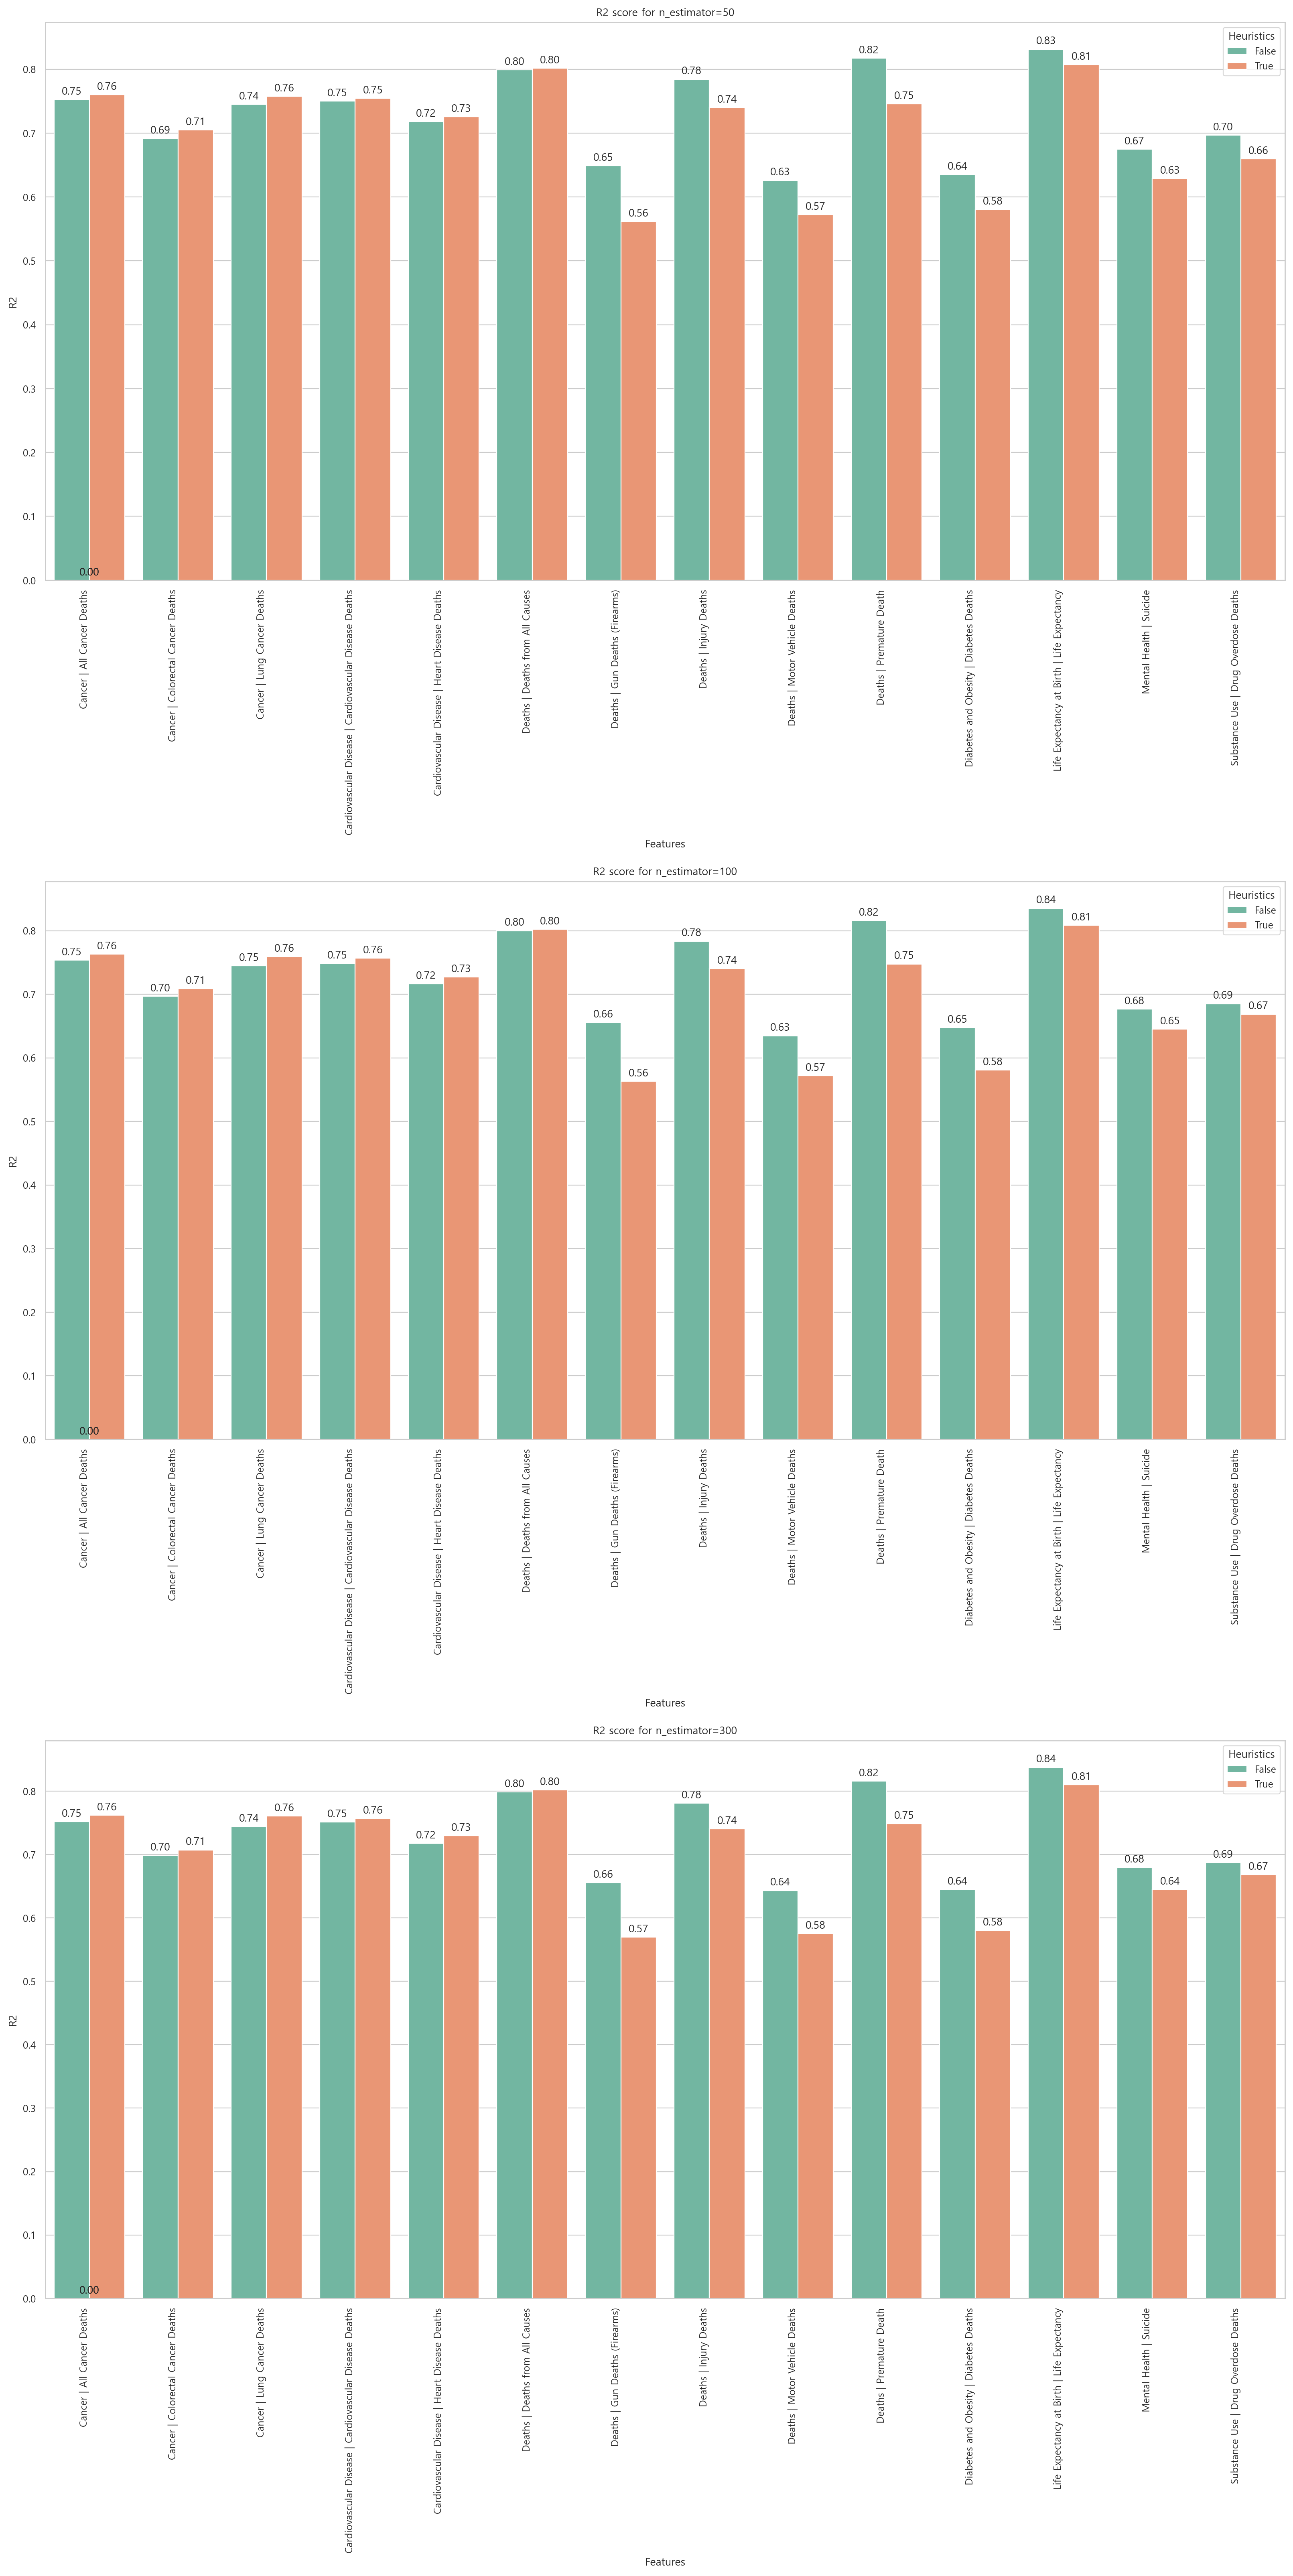

In [16]:
import seaborn as sns
import copy
fig ,axes = plt.subplots(3,1,figsize=(16,32))



for idx, key in enumerate(result_combined.keys()):
    data_dict = copy.deepcopy(result_combined[key])

    for val in data_dict.values():
        for val2 in val.values():
            del val2["feature_importance"]


    df_dict = nested_dict_to_df(data_dict).reset_index()

    df_dict = df_dict.rename(columns={"level_0": "Heuristics","level_2": "mode"})

    df_dict = df_dict[df_dict["mode"] == "test"]


    # pd.DataFrame.from_dict()

    sns.barplot(data=df_dict,x='level_1', y='r2', hue = 'Heuristics', ax=axes[idx])
    axes[idx].set_xticks(axes[idx].get_xticks(), axes[idx].get_xticklabels(), rotation=90, ha='right')

    axes[idx].set(xlabel="Features",ylabel="R2",title=f"R2 score for n_estimator={key}")

    for p in axes[idx].patches:
        axes[idx].annotate(f"{p.get_height():.2f}", (p.get_x() + p.get_width() / 2., p.get_height()),
                    ha='center', va='center', xytext =(0, 7), textcoords='offset points')

plt.savefig('rf_r2.png')

In [ ]:
# result_combined

In [ ]:
def add_value_labels(ax, spacing=5):
    """Add labels to the end of each bar in a bar chart.

    Arguments:
        ax (matplotlib.axes.Axes): The matplotlib object containing the axes
            of the plot to annotate.
        spacing (int): The distance between the labels and the bars.
    """

    # For each bar: Place a label
    for rect in ax.patches:
        # Get X and Y placement of label from rect.
        y_value = rect.get_height()
        x_value = rect.get_x() + rect.get_width() / 2

        # Number of points between bar and label. Change to your liking.
        space = spacing
        # Vertical alignment for positive values
        va = 'bottom'

        # If value of bar is negative: Place label below bar
        if y_value < 0:
            # Invert space to place label below
            space *= -1
            # Vertically align label at top
            va = 'top'

        # Use Y value as label and format number with one decimal place
        label = "{:.1f}".format(y_value)

        # Create annotation
        ax.annotate(
            label,                      # Use `label` as label
            (x_value, y_value),         # Place label at end of the bar
            xytext=(0, space),          # Vertically shift label by `space`
            textcoords="offset points", # Interpret `xytext` as offset in points
            ha='center',                # Horizontally center label
            va=va)                      # Vertically align label differently for
                                        # positive and negative values.


# Call the function above. All the magic happens there.


In [ ]:
# target = "Cancer | All Cancer Deaths"

n_est = 100

fig ,axes = plt.subplots(len(result_combined[n_est][True].keys()), 2, figsize=(30,120))

for i, h in enumerate(result_combined[n_est].keys()):
    for j, target in enumerate(result_combined[n_est][h].keys()):

        importance = result_combined[100][False][target]["feature_importance"]
        # ['feature_importance']
        # std = np.std([tree.feature_importances_ for tree in cities_rfc.estimators_], axis=0)
        avoid_list = avoid_list_orig
        if h:
            x_train = train_scaled.loc[train[train[target].notna()].index,train_scaled.columns.isin(strata_info) | (train_scaled.columns.isin(heuristic_list[target]) & ~(train_scaled.columns.isin(avoid_list)))]
        else:
            x_train = train_scaled.loc[train[train[target].notna()].index,train_scaled.columns.isin(strata_info) | ~(train_scaled.columns.isin(avoid_list) | train_scaled.columns.isin(target_cand) | train_scaled.columns.isin(city_info))]
        forest_importance = pd.Series(importance, index=x_train.columns)

        ax = axes[j][i]
        forest_importance.plot.bar(ax=ax)

        heuristics = "H" if h else ""
        ax.set(xlabel="Features",ylabel="Feature Importance",title=f"{target} {heuristics}")
        add_value_labels(ax)
plt.savefig("rf_featureimportance.png")

ValueError: Length of values (61) does not match length of index (12)

In [ ]:
result_combined[100][False]["Cancer | All Cancer Deaths"]["feature_importance"]#.values()

array([3.00536805e-01, 1.19768495e-01, 2.47024369e-04, 7.34578991e-04,
       1.13776947e-04, 2.83080729e-05, 6.96412169e-05, 2.66140313e-02,
       1.92008603e-03, 3.59870608e-03, 3.78564036e-02, 4.89487991e-03,
       1.93203565e-02, 2.53638894e-01, 2.81856356e-03, 2.19738957e-02,
       1.43467957e-02, 2.37617093e-03, 1.87283691e-03, 3.28669216e-03,
       4.29933504e-03, 2.14110559e-03, 9.37584968e-03, 8.81689070e-03,
       3.21390685e-03, 1.95948997e-03, 3.62730568e-03, 3.75298409e-03,
       2.21458045e-03, 7.92282939e-03, 4.27858014e-03, 4.54730188e-03,
       1.19618356e-02, 4.41653628e-03, 7.25490612e-03, 4.56572141e-03,
       3.98221501e-03, 4.78167713e-03, 2.21136460e-03, 2.56742218e-03,
       3.14129015e-03, 1.63985163e-03, 1.97672022e-03, 2.48649101e-03,
       5.08492666e-03, 3.10610596e-03, 3.54939755e-03, 4.08799198e-03,
       1.98835235e-03, 2.70271568e-03, 5.55725444e-03, 3.94551236e-03,
       3.36668869e-03, 3.37725511e-03, 4.24517090e-03, 2.52858690e-03,
      

In [ ]:
with open('results/rf/rf.pickle','wb') as fw:
        pickle.dump(result_combined, fw)

In [ ]:
#Random Forest Regressor

cities_rfc = RandomForestRegressor(n_estimators=100,oob_score=True,random_state=42)
cities_rfc.fit(x_train,y_train.values.ravel())

cities_pred_train = cities_rfc.predict(x_train)
cities_pred_test = cities_rfc.predict(x_test)

print('train mse: ' ,metrics.mean_squared_error(cities_pred_train,y_train))
print('test mse: ' ,metrics.mean_squared_error(cities_pred_test,y_test))

print('train r2: ' ,metrics.r2_score(cities_pred_train,y_train))
print('test r2: ' ,metrics.r2_score(cities_pred_test,y_test))

train mse:  3.3707897033585574
test mse:  476.8916003179086
train r2:  0.9953937808019574
test r2:  -0.2768738335125609


In [ ]:
# train의 y값 평균만 줬을때보단 얼마나 나을까?
print('baseline: ' ,metrics.mean_squared_error([y_train.mean()] * 52,y_test))

baseline:  787.128374698763


<Axes: >

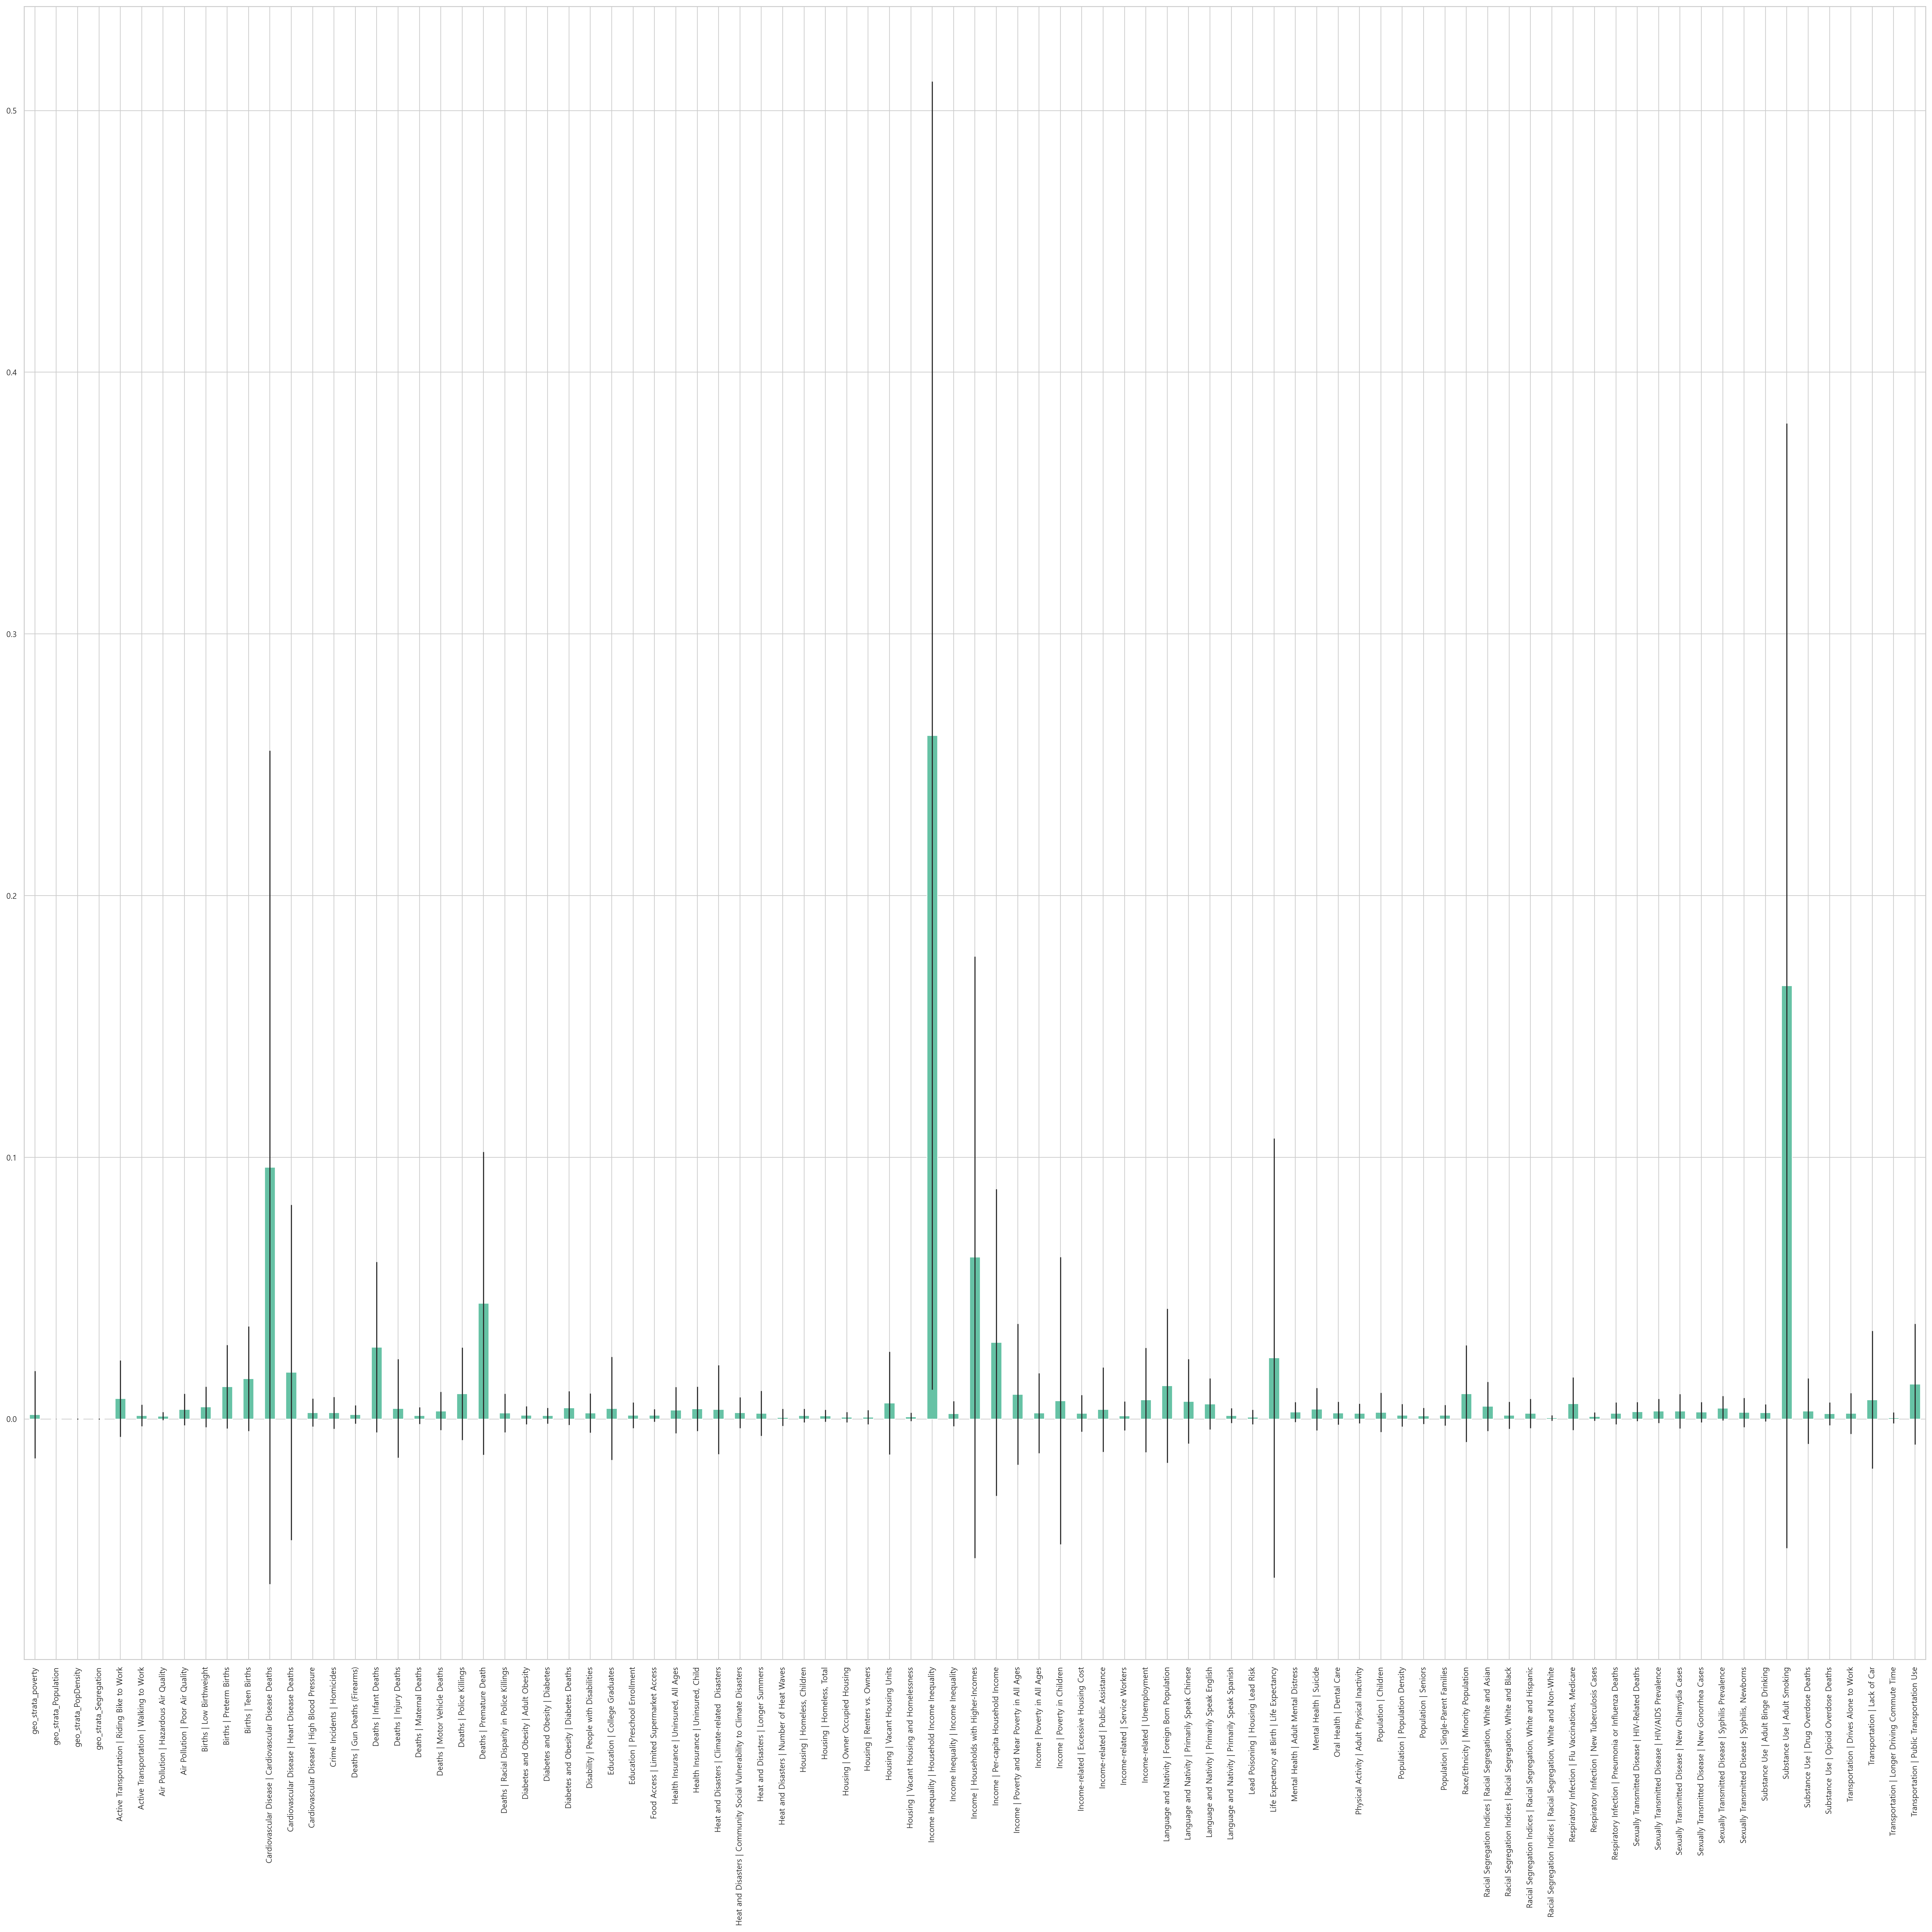

In [ ]:
#feature importance 계산
importance = cities_rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in cities_rfc.estimators_], axis=0)

forest_importance = pd.Series(importance, index=x_train.columns)

fig ,ax = plt.subplots(figsize=(30,30))
forest_importance.plot.bar(yerr=std,ax=ax)

In [ ]:
def threshold(p):
    return np.quantile(forest_importance,p).item()

In [ ]:
df_importance = forest_importance.to_frame()

#95%
display(df_importance[df_importance[0] > threshold(0.95)])
#90%
display(df_importance[df_importance[0] > threshold(0.9)])
#10%
display(df_importance[df_importance[0] < threshold(0.1)])
#5%
display(df_importance[df_importance[0] < threshold(0.05)])

,0
Cardiovascular Disease | Cardiovascular Disease Deaths,0.096171
Deaths | Premature Death,0.044214
Income Inequality | Household Income Inequality,0.261151
Income | Households with Higher-Incomes,0.061838
Substance Use | Adult Smoking,0.165600


,0
Cardiovascular Disease | Cardiovascular Disease Deaths,0.096171
Cardiovascular Disease | Heart Disease Deaths,0.017802
Deaths | Infant Deaths,0.027467
Deaths | Premature Death,0.044214
Income Inequality | Household Income Inequality,0.261151
Income | Households with Higher-Incomes,0.061838
Income | Per-capita Household Income,0.029250
Life Expectancy at Birth | Life Expectancy,0.023309
Substance Use | Adult Smoking,0.165600


,0
geo_strata_Population,0.000012
geo_strata_PopDensity,0.000025
geo_strata_Segregation,0.000022
Heat and Disasters | Number of Heat Waves,0.000626
Housing | Owner Occupied Housing,0.000668
Housing | Renters vs. Owners,0.000730
Lead Poisoning | Housing Lead Risk,0.000748
"Racial Segregation Indices | Racial Segregation, White and Non-White",0.000411
Transportation | Longer Driving Commute Time,0.000447


,0
geo_strata_Population,0.000012
geo_strata_PopDensity,0.000025
geo_strata_Segregation,0.000022
"Racial Segregation Indices | Racial Segregation, White and Non-White",0.000411
Transportation | Longer Driving Commute Time,0.000447


In [ ]:
#지워볼만한 항목들
df_importance.index[df_importance[0] < threshold(0.1)]

Index(['geo_strata_Population', 'geo_strata_PopDensity',
       'geo_strata_Segregation', 'Deaths | Maternal Deaths',
       'Heat and Disasters | Number of Heat Waves',
       'Housing | Owner Occupied Housing', 'Income-related | Service Workers',
       'Population | Population Density',
       'Racial Segregation Indices | Racial Segregation, White and Non-White'],
      dtype='object')

In [ ]:
#위의 항목들 지우고 다시 하려면 여기 코드로 데이터 다시 정립
# avoid_list += df_importance.index[df_importance[0] < threshold(0.1)].to_list()

# x_train = train_scaled.loc[:,~(train_scaled.columns.isin(avoid_list) | train_scaled.columns.isin(target_list) | train_scaled.columns.isin(city_info))]#features_list]
# y_train = train[target_list]

# x_test = test_scaled.loc[:,~(test_scaled.columns.isin(avoid_list) | test_scaled.columns.isin(target_list) | test_scaled.columns.isin(city_info))]#features_list]
# y_test = test[target_list]

In [ ]:
#heuristic하게 고른 항목들로만 하면 얼마나 나을까?

heuristic_list = ["Cancer | Breast Cancer Deaths",
"Cancer | Prostate Cancer Deaths",
"Physical Activity | Adult Physical Inactivity",
"Diabetes and Obesity | Diabetes",
"Diabetes and Obesity | Teen Obesity",
"Diabetes and Obesity | Adult Obesity",
"Dietary Quality | Teen Soda",
"Population | Seniors",
"Health Insurance | Uninsured, All Ages",
"Births | Low Birthweight",
"Births | Prenatal Care",
"Births | Preterm Births",
"Births | Teen Births",
"Income | Poverty in All Ages"]

x_train = x_train = train_scaled.loc[:,train_scaled.columns.isin(heuristic_list) & ~(train_scaled.columns.isin(avoid_list))]#features_list]
y_train = train[target_list]

x_test = test_scaled.loc[:,test_scaled.columns.isin(heuristic_list) & ~(test_scaled.columns.isin(avoid_list))]#features_list]
y_test = test[target_list]

In [ ]:
# msno.matrix(x_train)
# x_train = x_train.apply(lambda x: x.fillna(x.mean()),axis=0)

In [ ]:
cities_rfc = RandomForestRegressor(n_estimators=100,oob_score=True,random_state=42)
cities_rfc.fit(x_train,y_train.values.ravel())

cities_pred_train = cities_rfc.predict(x_train)
cities_pred_test = cities_rfc.predict(x_test)

print('train mse: ' ,metrics.mean_squared_error(cities_pred_train,y_train))
print('test mse: ' ,metrics.mean_squared_error(cities_pred_test,y_test))
print('baseline mse: ' ,metrics.mean_squared_error([y_train.mean()] * 52,y_test))

print('train rmsle: ' ,metrics.root_mean_squared_log_error(cities_pred_train,y_train))
print('test rmsle: ' ,metrics.root_mean_squared_log_error(cities_pred_test,y_test))
print('baseline rmsle: ' ,metrics.root_mean_squared_log_error([y_train.mean()] * 52,y_test))

train mse:  8.308217032767253
test mse:  429.2898050422067
baseline mse:  787.128374698763
train rmsle:  0.01772984881591639
test rmsle:  0.1281389012648688
baseline rmsle:  0.1771112323961681


<Axes: >

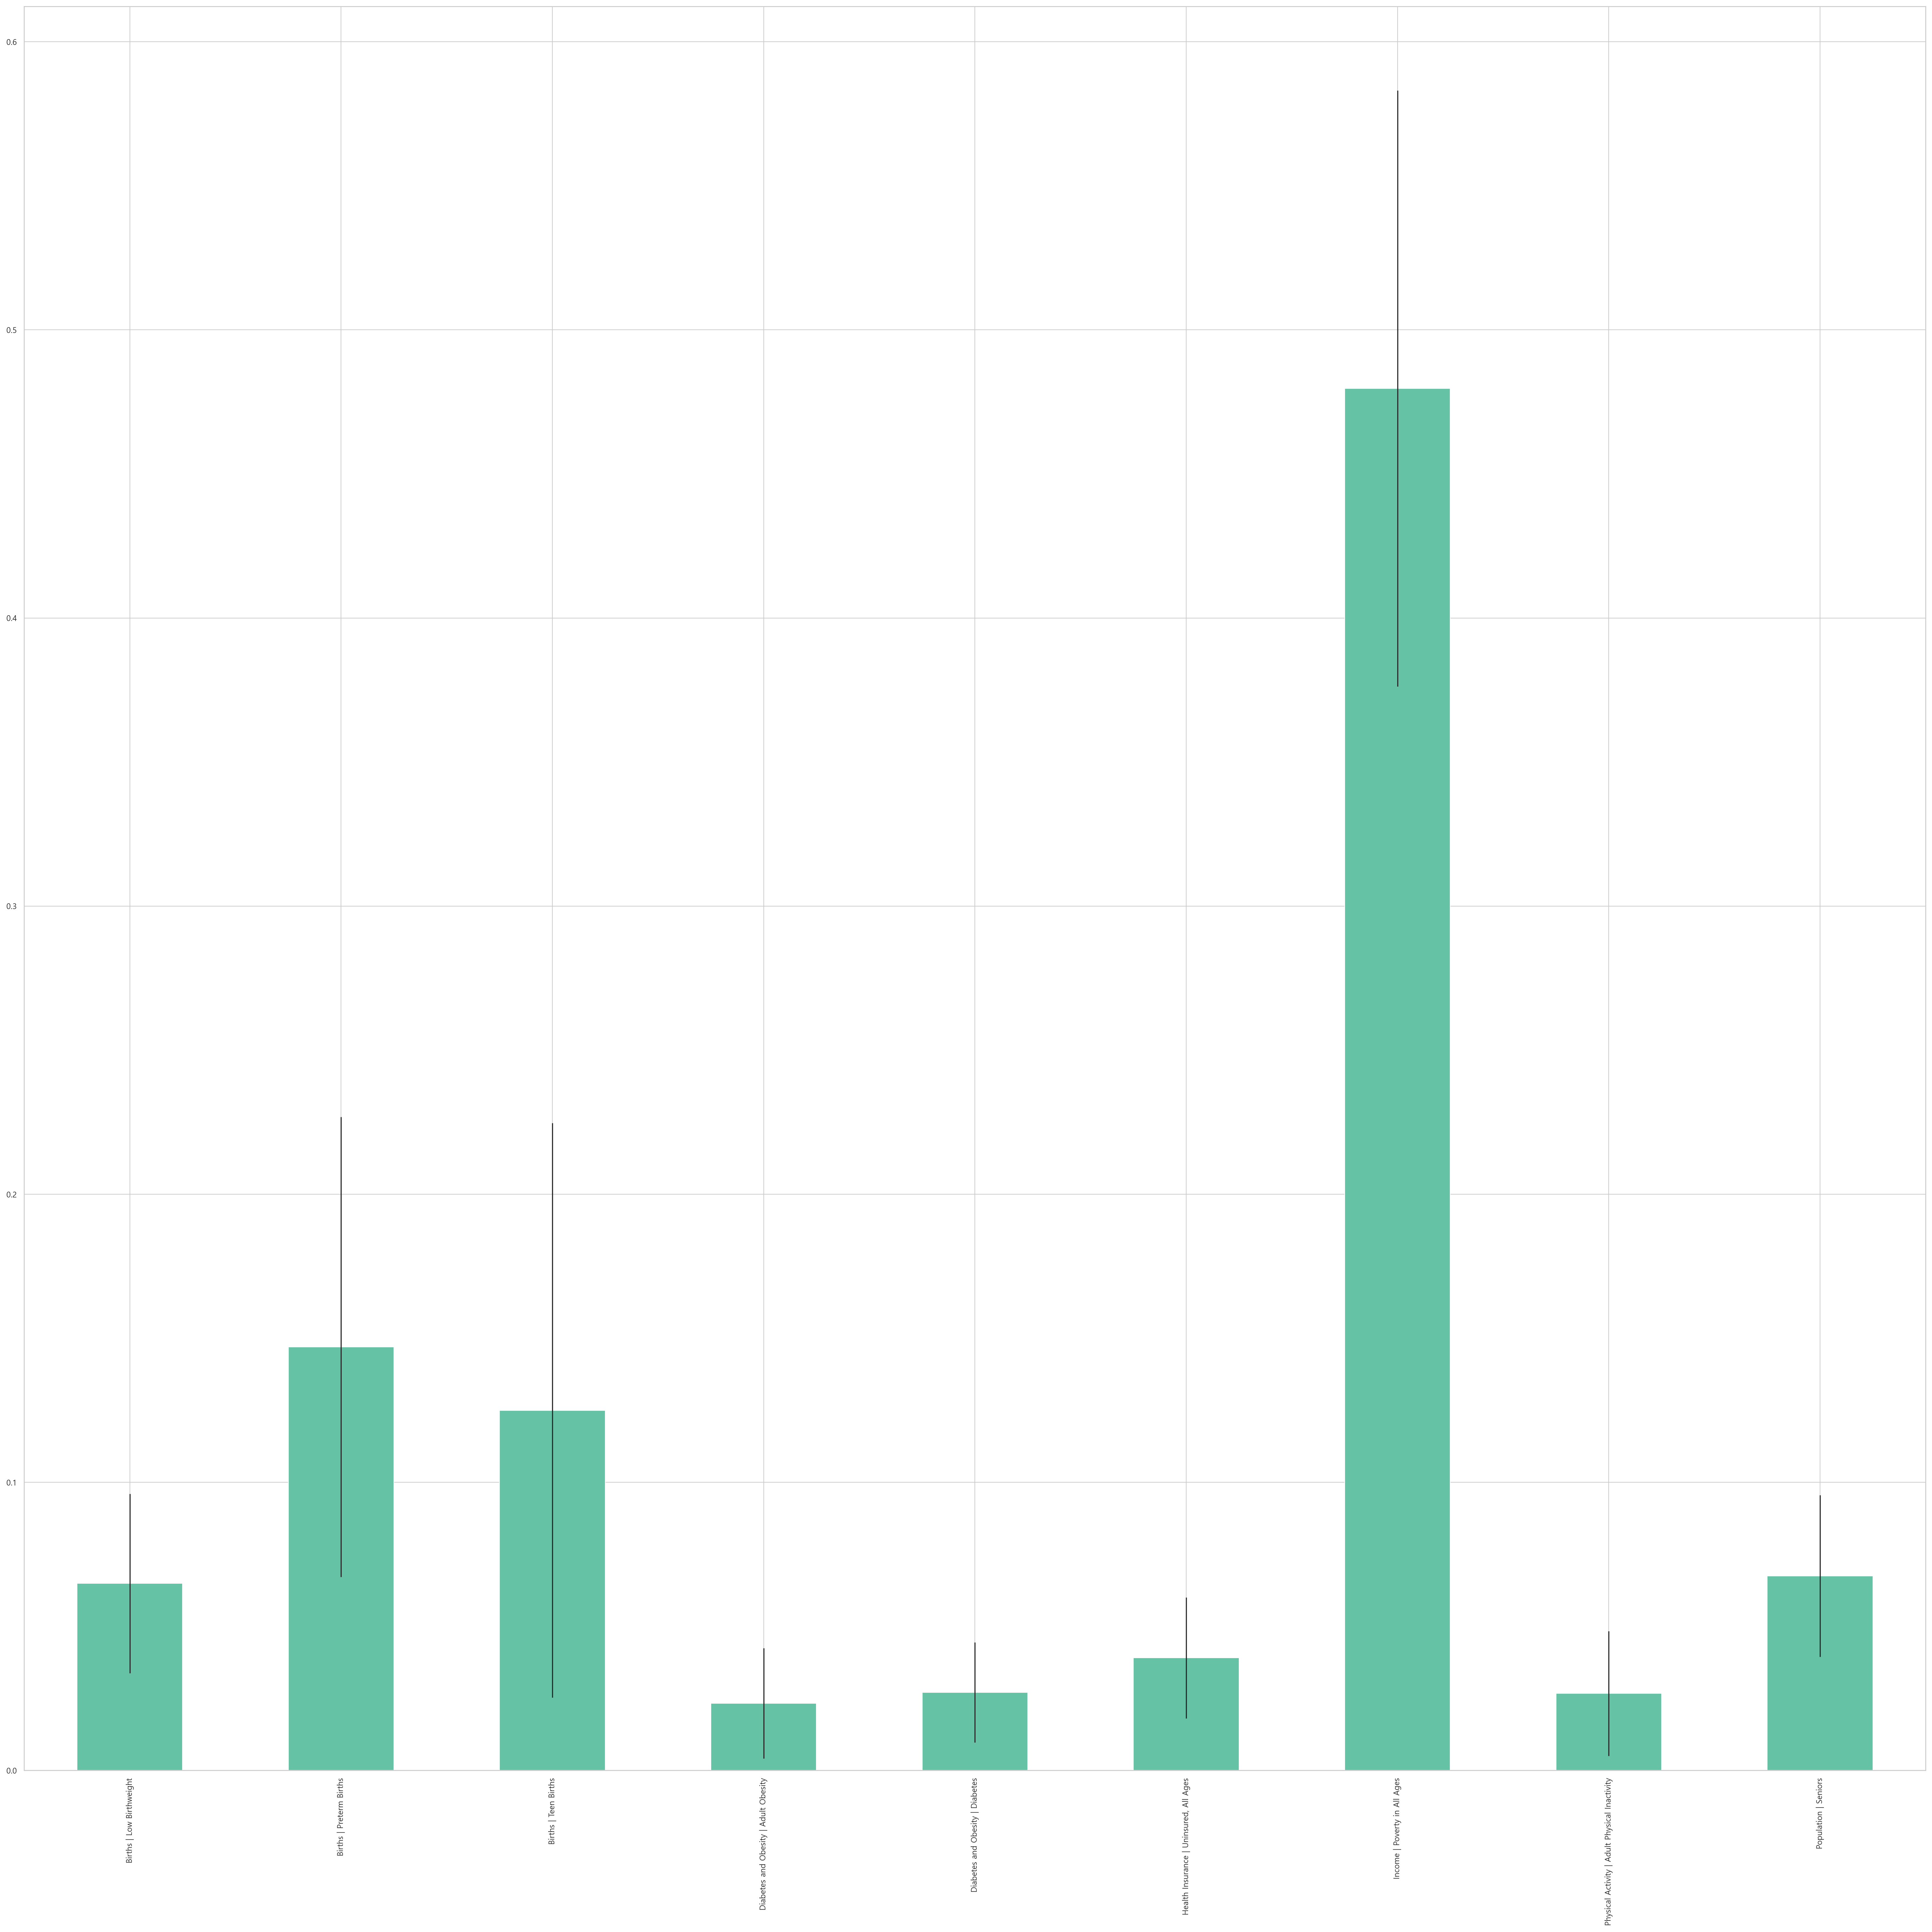

In [ ]:
importance = cities_rfc.feature_importances_
std = np.std([tree.feature_importances_ for tree in cities_rfc.estimators_], axis=0)

forest_importance = pd.Series(importance, index=x_train.columns)

fig ,ax = plt.subplots(figsize=(30,30))
forest_importance.plot.bar(yerr=std,ax=ax)

In [ ]:
df_importance = forest_importance.to_frame()

#95%
display(df_importance[df_importance[0] > threshold(0.95)])
#90%
display(df_importance[df_importance[0] > threshold(0.9)])
#10%
display(df_importance[df_importance[0] < threshold(0.1)])
#5%
display(df_importance[df_importance[0] < threshold(0.05)])

NameError: name 'threshold' is not defined